## DataFrame benchmarks with object vs. string[pyarrow] data

In [ ]:
import dask
dask.utils.show_versions()

In [ ]:
import pandas as pd
import numpy as np
from dask.sizeof import sizeof
from dask.utils import format_bytes
from dask import delayed
from dask.distributed import PipInstall, PackageInstall
import dask.dataframe as dd
import random
import string
from distributed import wait
from distributed import Client
from distributed.diagnostics import MemorySampler
import coiled
import matplotlib
import matplotlib.pyplot as plt


In [ ]:
cluster = coiled.Cluster(
    name="pyarrow-dask-benchmarking",
    n_workers=10,
    package_sync=True,
)

In [ ]:
#plugin = PipInstall(packages=["s3fs"])
#client.register_worker_plugin(plugin, name="s3fs")

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
cluster

In [ ]:
client = Client(cluster)
client

In [ ]:
client = cluster.get_client()
client

In [ ]:
from dask.distributed import PipInstall
plugin = PipInstall(packages=["s3fs"])
client.register_worker_plugin(plugin)

In [ ]:
file_paths = [
    f"s3://nyc-tlc/trip data/yellow_tripdata_{year}*.parquet"
    for year in (2021, 2022)
]
file_paths

In [ ]:
ddf = dd.read_parquet(
    file_paths,
    columns=["VendorID", "passenger_count", "trip_distance", "store_and_fwd_flag", "total_amount"],
)

In [ ]:
wait(ddf);

In [ ]:
ddf.head(3)

In [ ]:
ddf

In [ ]:
wait(ddf);

In [ ]:
ddf.dtypes

In [ ]:
ddf.size.compute()

In [ ]:
ddf = ddf.repartition(partition_size="100Mb").persist()

In [ ]:
ddf.npartitions

In [ ]:
ddf.memory_usage_per_partition().compute()

In [21]:
with dask.config.set({"dataframe.convert_string": True}):
    ddf2 = dd.read_parquet(
        file_paths,
        columns=["VendorID", "passenger_count", "trip_distance", "store_and_fwd_flag", "total_amount"],
        split_row_groups=True,
    )

In [ ]:
wait(ddf2);

In [22]:
ddf2 = ddf2.repartition(partition_size="100Mb").persist()

In [ ]:
ddf2.npartitions

In [ ]:
ddf2.memory_usage_per_partition().compute()

In [23]:
ddf2.dtypes

VendorID                        int64
passenger_count               float64
trip_distance                 float64
store_and_fwd_flag    string[pyarrow]
total_amount                  float64
dtype: object

In [ ]:
ms1 = MemorySampler()
ms2 = MemorySampler()
ms3 = MemorySampler()
ms4 = MemorySampler()
ms5 = MemorySampler()
ms6 = MemorySampler()

In [15]:
# 1
with ms1.sample("object string", interval=0.01):
    %timeit -r 5 -n 2 ddf.store_and_fwd_flag.unique().compute()

325 ms ± 72.3 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [24]:
# 1, ddf2
with ms1.sample("arrow string", interval=0.01):
    %timeit -r 5 -n 2 ddf2.store_and_fwd_flag.unique().compute()

The slowest run took 21.46 times longer than the fastest. This could mean that an intermediate result is being cached.
46.9 ms ± 49.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Unique'}, xlabel='time', ylabel='Cluster memory (GiB)'>

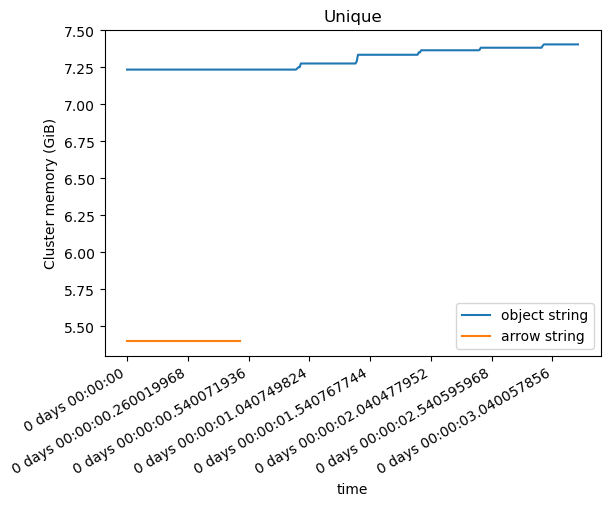

In [25]:
ms1.plot(align=True, title="Unique")

In [16]:
# 2
with ms2.sample("object string", interval=0.1):
    %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").total_amount.sum().compute()

626 ms ± 8.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [26]:
# 2, ddf2
with ms2.sample("arrow string"):
    %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").total_amount.sum().compute()

223 ms ± 4.87 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Groupby/sum'}, xlabel='time', ylabel='Cluster memory (GiB)'>

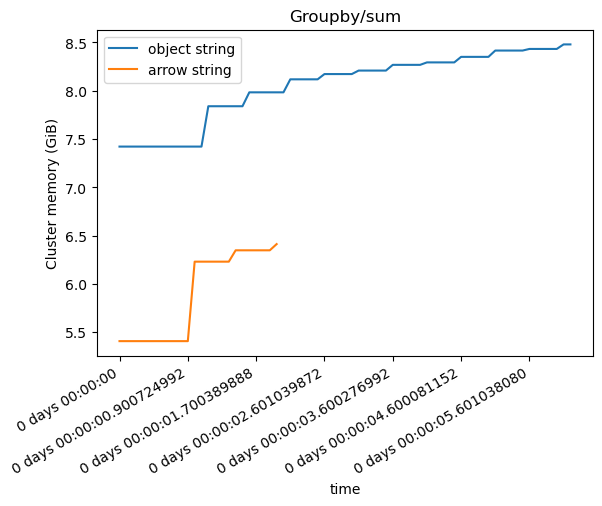

In [27]:
ms2.plot(align=True, title="Groupby/sum")

In [17]:
# 3
with ms3.sample("object string", interval=0.05):
    %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").trip_distance.mean().compute()

1 s ± 222 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [28]:
# 3, ddf2
with ms3.sample("arrow string", interval=0.05):
    %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").trip_distance.mean().compute()

407 ms ± 7.82 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Groupby/mean'}, xlabel='time', ylabel='Cluster memory (GiB)'>

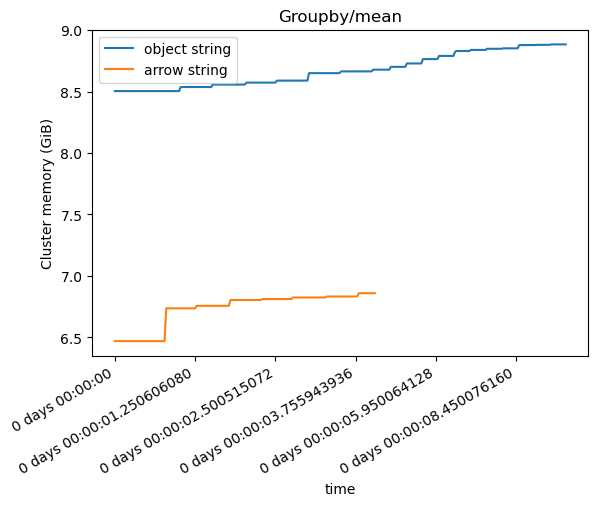

In [29]:
ms3.plot(align=True, title="Groupby/mean")

In [ ]:
# 4
with ms4.sample("object string"):
    %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").trip_distance.median().compute()

In [ ]:
#4, ddf2
with ms4.sample("arrow string"):
    %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").trip_distance.median().compute()

In [ ]:
ms4.plot(align=True, title="Groupby/median")

In [18]:
# 5
with ms5.sample("object string", interval=0.1):
    %timeit -r 5 -n 2 ddf.store_and_fwd_flag.str.len().compute()

2.54 s ± 15.7 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [30]:
# 5, ddf2
with ms5.sample("arrow string", interval=0.1):
    %timeit -r 5 -n 2 ddf2.store_and_fwd_flag.str.len().compute()

605 ms ± 21.9 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'String length'}, xlabel='time', ylabel='Cluster memory (GiB)'>

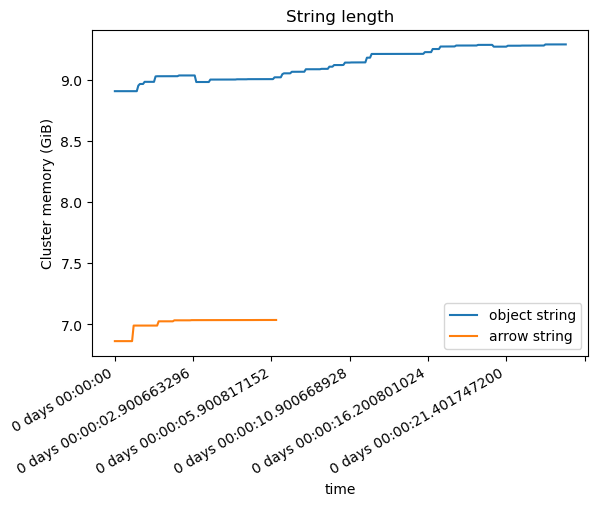

In [31]:
ms5.plot(align=True, title="String length")

In [19]:
# 6
with ms6.sample("object string", interval=0.1):
    %timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").passenger_count.sum().compute()

The slowest run took 44.37 times longer than the fastest. This could mean that an intermediate result is being cached.
203 ms ± 159 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [32]:
#6, ddf2
with ms6.sample("arrow string", interval=0.1):
    %timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").passenger_count.sum().compute()

227 ms ± 4.33 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


<Axes: title={'center': 'Groupby/sum 2'}, xlabel='time', ylabel='Cluster memory (GiB)'>

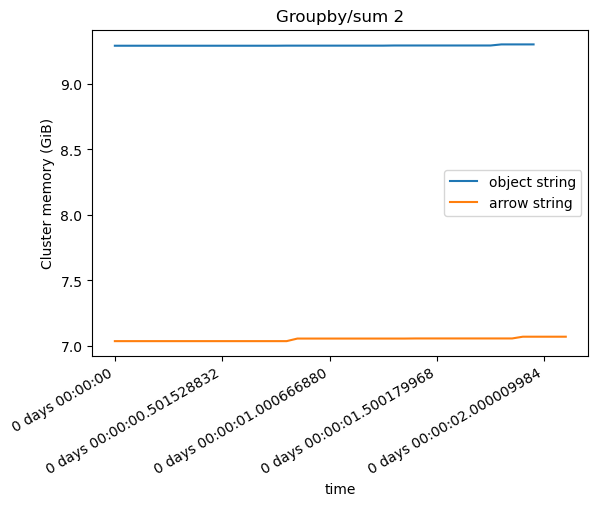

In [33]:
ms6.plot(align=True, title="Groupby/sum 2")

In [20]:
client.restart()  # Release futures and clear up memory on the cluster

2023-03-27 18:03:15,576 - distributed.nanny - WARNING - Restarting worker
2023-03-27 18:03:15,591 - distributed.nanny - WARNING - Restarting worker
2023-03-27 18:03:15,596 - distributed.nanny - WARNING - Restarting worker
2023-03-27 18:03:15,600 - distributed.nanny - WARNING - Restarting worker


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51493,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: 3 minutes ago,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:51657,Total threads: 3
Dashboard: http://127.0.0.1:51658/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:51496,


In [34]:
client.close()

In [35]:
cluster.close()